In [ ]:
import pandas as pd
import re
import pickle
import nltk
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
stopwords = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train = pd.read_csv("drive/MyDrive/dataset/train.csv")

In [ ]:
print(train.isnull().sum())

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64


# Text normalization

In [ ]:
RE_PATTERNS = pickle.load(open("drive/MyDrive/dataset/re_patterns", "rb"))

In [ ]:
def clean_text(text):

  text=text.lower()

  for target, patterns in RE_PATTERNS.items():
    for pat in patterns:
      text=str(text).replace(pat, target)

  text = re.sub(r'(.)\1{2,}', r'\1', text) #repeated text

  text = str(text).replace("\n", " ") #\n
  text = re.sub(r'[^\w\s]',' ',text) #white spaces
  text = re.sub('[0-9]',"",text) # numbers
  text = re.sub(" +", " ", text) # extra spaces
  text = re.sub("([^\x00-\x7F])+"," ",text) #punctuation
  return text

In [ ]:
def lemma(text):
  wordnet_lemmatizer = WordNetLemmatizer()
  output=""
  text=text.split(" ")
  for word in text:
      word1 = wordnet_lemmatizer.lemmatize(word, pos = "n")
      word2 = wordnet_lemmatizer.lemmatize(word1, pos = "v")
      word3 = wordnet_lemmatizer.lemmatize(word2, pos = "a")
      word4 = wordnet_lemmatizer.lemmatize(word3, pos = "r")
      output=output + " " + word4

  return str(output.strip())

In [ ]:
def remove_stopwords(text):
  output = ""
  text=text.split(" ")
  for word in text:
    if word not in stopwords:
      output=output + " " + word
  return str(output.strip())

In [ ]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
train['comment_text'] = train['comment_text'].apply(lambda x : clean_text(x))

In [ ]:
train['comment_text'] = train['comment_text'].apply(lambda x : lemma(x))

In [ ]:
train['comment_text'] = train['comment_text'].apply(lambda x : remove_stopwords(clean_text(x)))

In [ ]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation edit make username hardcore metall...,0,0,0,0,0,0
1,000103f0d9cfb60f,aww match background colour seemingly stick th...,0,0,0,0,0,0
2,000113f07ec002fd,hey man really try edit war guy constantly rem...,0,0,0,0,0,0
3,0001b41b1c6bb37e,make real suggestion improvement wonder sectio...,0,0,0,0,0,0
4,0001d958c54c6e35,sir hero chance remember page,0,0,0,0,0,0


# EDA

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

%matplotlib inline

# Visualization
import seaborn as sns
from matplotlib import pyplot as plt

import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from matplotlib_venn import venn3

from wordcloud import WordCloud

from collections import Counter
import re
import string
from nltk.corpus import stopwords
stop = stopwords.words('english')


sns.set(style="white", context="talk")

In [ ]:
df_train = pickle.load(open("drive/MyDrive/dataset/train", "rb"))

In [ ]:
COLUMNS = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']



# Adding 'none' columns if there is no '1' in COLUMNS
df_train['none'] = (df_train[COLUMNS].max(axis=1) == 0).astype(int)
COLUMNS.append('none')
CATEGORIES = COLUMNS.copy()

print(df_train.shape)
print(df_train.columns.values)

(159571, 9)
['id' 'comment_text' 'toxic' 'severe_toxic' 'obscene' 'threat' 'insult'
 'identity_hate' 'none']


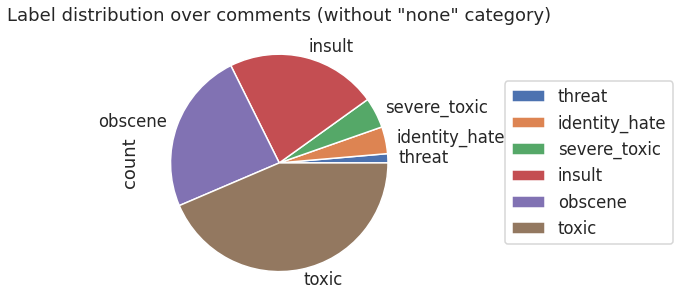

In [ ]:
df_distribution = df_train[COLUMNS].sum()\
                            .to_frame()\
                            .rename(columns={0: 'count'})\
                            .sort_values('count')

df_distribution.drop('none').plot.pie(y='count',
                                      title='Label distribution over comments (without "none" category)',
                                      figsize=(5, 5))\
                            .legend(loc='center left', bbox_to_anchor=(1.3, 0.5))

In [ ]:
df_distribution.sort_values('count', ascending=False)

,count
none,143346
toxic,15294
obscene,8449
insult,7877
severe_toxic,1595
identity_hate,1405
threat,478


In [ ]:
df_comb = df_train.groupby(COLUMNS)\
                    .size()\
                    .sort_values(ascending=False)\
                    .reset_index()\
                    .rename(columns={0: 'count'})
df_comb.head(n=10)

,toxic,severe_toxic,obscene,threat,insult,identity_hate,none,count
0,0,0,0,0,0,0,1,143346
1,1,0,0,0,0,0,0,5666
2,1,0,1,0,1,0,0,3800
3,1,0,1,0,0,0,0,1758
4,1,0,0,0,1,0,0,1215
5,1,1,1,0,1,0,0,989
6,1,0,1,0,1,1,0,618
7,0,0,1,0,0,0,0,317
8,0,0,0,0,1,0,0,301
9,1,1,1,0,1,1,0,265


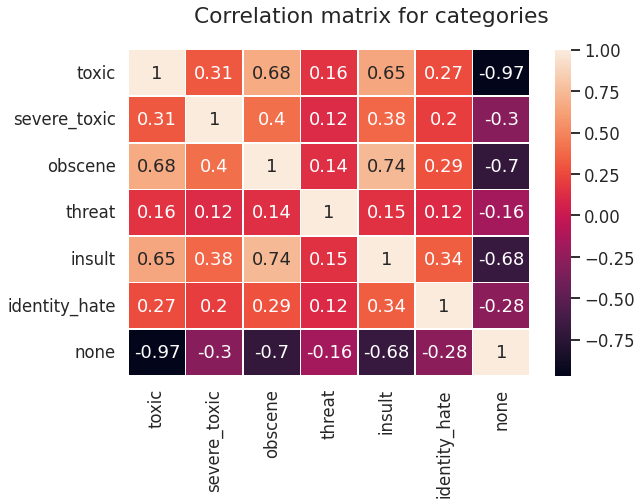

In [ ]:
f, ax = plt.subplots(figsize=(9, 6))
f.suptitle('Correlation matrix for categories')
sns.heatmap(df_train[COLUMNS].corr(), annot=True, linewidths=.5, ax=ax)

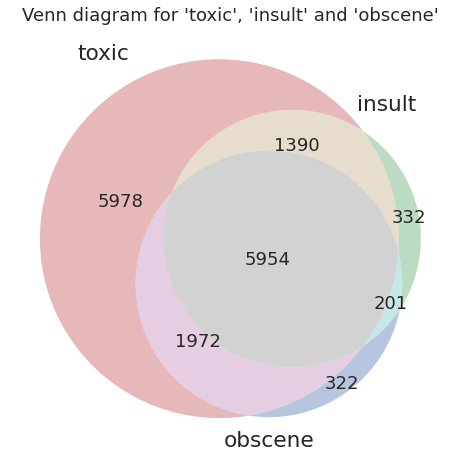

In [ ]:
t = df_train[(df_train['toxic'] == 1) & (df_train['insult'] == 0) & (df_train['obscene'] == 0)].shape[0]
i = df_train[(df_train['toxic'] == 0) & (df_train['insult'] == 1) & (df_train['obscene'] == 0)].shape[0]
o = df_train[(df_train['toxic'] == 0) & (df_train['insult'] == 0) & (df_train['obscene'] == 1)].shape[0]

t_i = df_train[(df_train['toxic'] == 1) & (df_train['insult'] == 1) & (df_train['obscene'] == 0)].shape[0]
t_o = df_train[(df_train['toxic'] == 1) & (df_train['insult'] == 0) & (df_train['obscene'] == 1)].shape[0]
i_o = df_train[(df_train['toxic'] == 0) & (df_train['insult'] == 1) & (df_train['obscene'] == 1)].shape[0]

t_i_o = df_train[(df_train['toxic'] == 1) & (df_train['insult'] == 1) & (df_train['obscene'] == 1)].shape[0]


# Make the diagram
plt.figure(figsize=(8, 8))
plt.title("Venn diagram for 'toxic', 'insult' and 'obscene'")
venn3(subsets = (t, i, t_i, o, t_o, i_o, t_i_o),
      set_labels=('toxic', 'insult', 'obscene'))
plt.show()

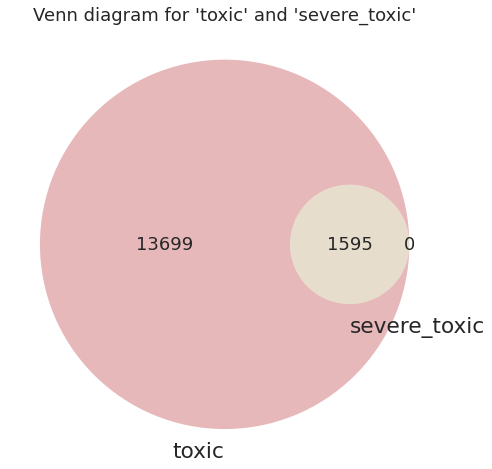

In [ ]:
t = df_train[(df_train['toxic'] == 1) & (df_train['severe_toxic'] == 0)].shape[0]
s = df_train[(df_train['toxic'] == 0) & (df_train['severe_toxic'] == 1)].shape[0]

t_s = df_train[(df_train['toxic'] == 1) & (df_train['severe_toxic'] == 1)].shape[0]


# Make the diagram
plt.figure(figsize=(8, 8))
plt.title("Venn diagram for 'toxic' and 'severe_toxic'")
venn2(subsets = (t, s, t_s),
      set_labels=('toxic', 'severe_toxic'))
plt.show()


In [ ]:
df_train['total_length'] = df_train['comment_text'].str.len()

FEATURES = ['total_length']
COLUMNS += FEATURES

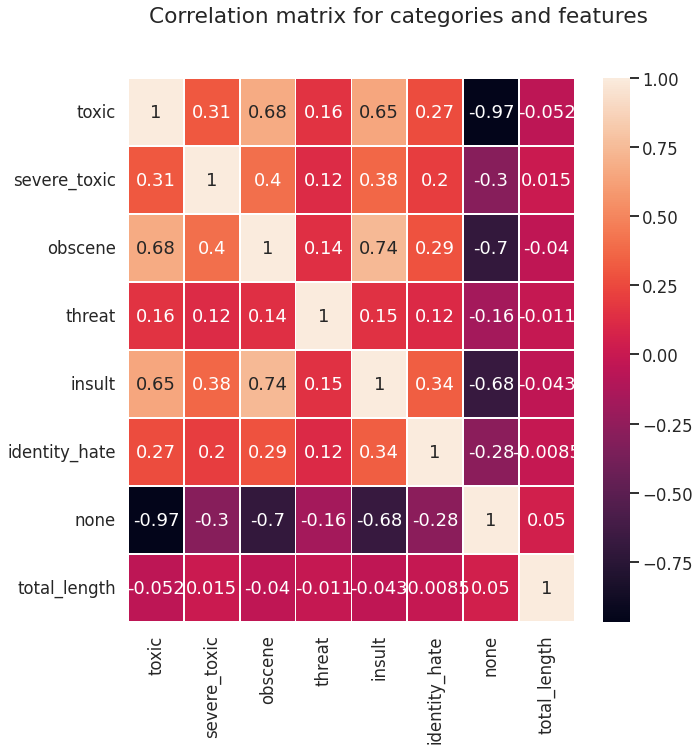

In [ ]:
f, ax = plt.subplots(figsize=(10, 10))
f.suptitle('Correlation matrix for categories and features')
sns.heatmap(df_train[COLUMNS].corr(), annot=True, linewidths=.5, ax=ax)

In [ ]:
word_counter = {}
for categ in CATEGORIES:
    d = Counter()
    df_train[df_train[categ] == 1]['comment_text'].apply(lambda t: d.update(t.split()))
    word_counter[categ] = pd.DataFrame.from_dict(d, orient='index')\
                                        .rename(columns={0: 'count'})\
                                        .sort_values('count', ascending=False)

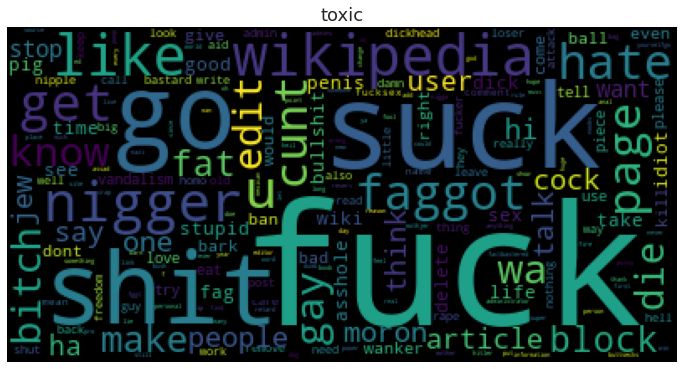

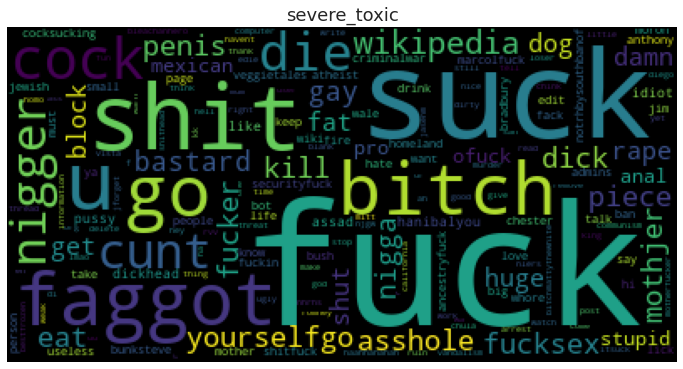

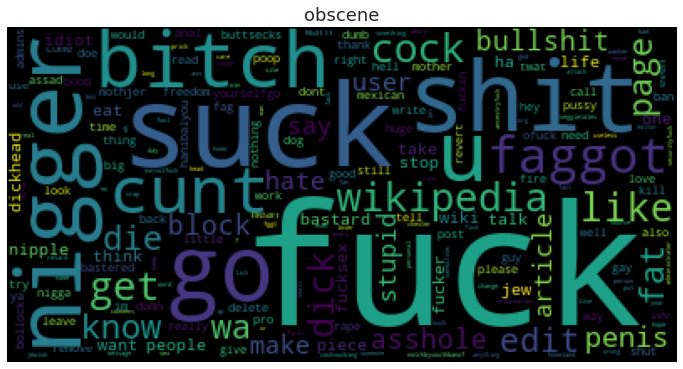

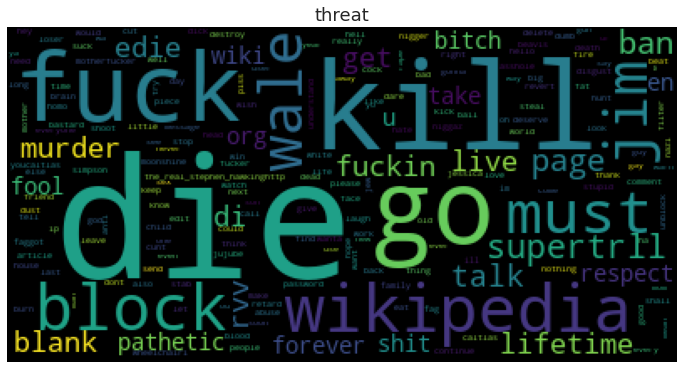

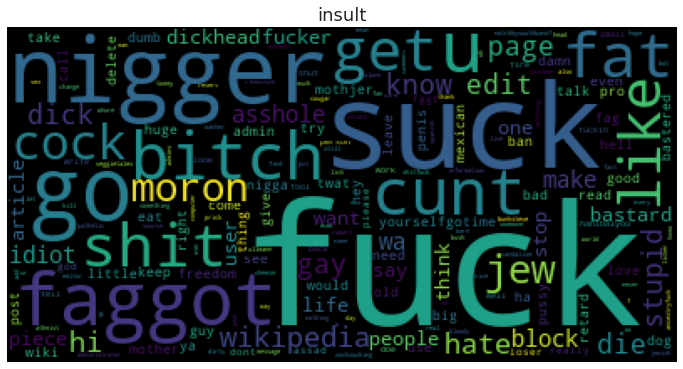

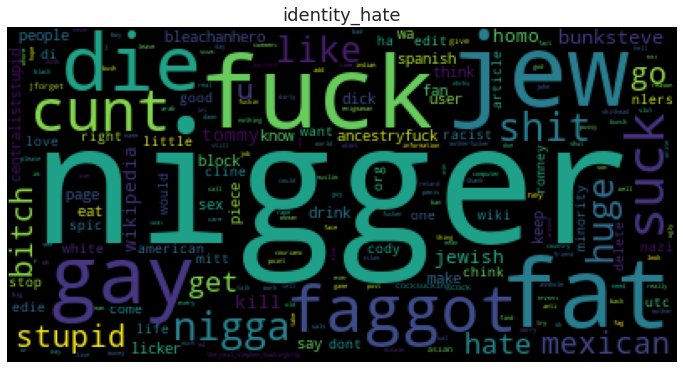

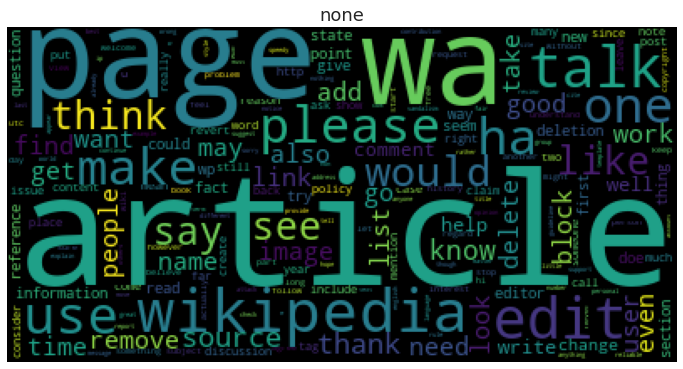

In [ ]:
for w in word_counter:
    wc = word_counter[w]

    wordcloud = WordCloud(
          background_color='black',
          max_words=200,
          max_font_size=100,
          random_state=4561
         ).generate_from_frequencies(wc.to_dict()['count'])

    fig = plt.figure(figsize=(12, 8))
    plt.title(w)
    plt.imshow(wordcloud)
    plt.axis('off')

    plt.show()

# Tokenization and padding

In [ ]:
import pandas as pd
import pickle
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras import initializers, regularizers, constraints, optimizers, layers

In [ ]:
train = pickle.load(open("drive/MyDrive/dataset/train", "rb"))

In [ ]:
classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[classes]
x = train["comment_text"]

In [ ]:
print("Before tokenization")
print(x[0:5])

Before tokenization
0    explanation edit make username hardcore metall...
1    aww match background colour seemingly stick th...
2    hey man really try edit war guy constantly rem...
3    make real suggestion improvement wonder sectio...
4                        sir hero chance remember page
Name: comment_text, dtype: object


In [ ]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(x))
x = tokenizer.texts_to_sequences(x)

In [ ]:
print("After tokenization")
print(x[0:5])

After tokenization
[[482, 5, 10, 553, 3420, 8746, 619, 71, 135, 4810, 1953, 434, 65, 1002, 8747, 2203, 11, 38, 195, 6, 2, 85, 2038], [11981, 883, 441, 2082, 3456, 755, 19, 6, 814, 118], [303, 301, 79, 60, 5, 140, 253, 1826, 38, 397, 49, 6, 5, 263, 6, 2, 67, 279, 628, 607, 354], [10, 238, 597, 1202, 508, 59, 1832, 244, 2642, 330, 2383, 14, 70, 30, 29, 4062, 1197, 628, 1629, 222, 628, 230, 244, 9, 212, 51, 62, 1964, 628, 183, 70, 34, 11, 115, 17, 186, 4107, 1, 164, 467, 30, 1434, 1802, 571, 45, 397, 352, 2772, 4, 25, 1, 3203], [1361, 2142, 787, 446, 2]]


In [ ]:
maxlen = 200
x = pad_sequences(x, maxlen=maxlen)

In [ ]:
print("After padding")
print(x[0:2])

After padding
[[    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     

In [ ]:
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D, SimpleRNN, GRU, Flatten, Conv1D, MaxPooling1D
from keras.models import Model
from keras import metrics

In [ ]:
from keras.utils.vis_utils import plot_model
from PIL import Image

def predict_dl(inp, l, epochs = 2):
  global x
  global y
  model = Model(inputs=inp, outputs=l)
  model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', metrics.Precision(name='precision'),
        metrics.Recall(name='recall')])
  batch_size = 32
  plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
  im = Image.open("model_plot.png")
  display(im)

  model.fit(x,y, batch_size=batch_size, epochs=epochs, validation_split = 0.2)

# LSTM

In [ ]:
inp = Input(shape=(maxlen, ))
embed_size = 128
e = Embedding(max_features, embed_size)(inp)

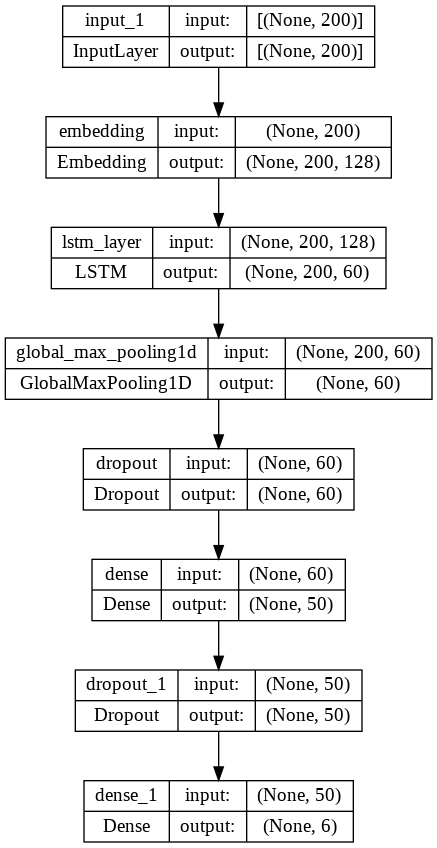

Epoch 1/2
3990/3990 [==============================] - 61s 14ms/step - loss: 0.0697 - accuracy: 0.9548 - precision: 0.7904 - recall: 0.5294 - val_loss: 0.0525 - val_accuracy: 0.9941 - val_precision: 0.8687 - val_recall: 0.5522
Epoch 2/2
3990/3990 [==============================] - 57s 14ms/step - loss: 0.0471 - accuracy: 0.9887 - precision: 0.8205 - recall: 0.6628 - val_loss: 0.0485 - val_accuracy: 0.9927 - val_precision: 0.8267 - val_recall: 0.6354


In [ ]:
l = LSTM(60, return_sequences=True,name='lstm_layer')(e)
l = GlobalMaxPool1D()(l)
l = Dropout(0.1)(l)
l = Dense(50, activation="relu")(l)
l = Dropout(0.1)(l)
l = Dense(6, activation="sigmoid")(l)
predict_dl(inp, l, 2)

# Deep nueral network

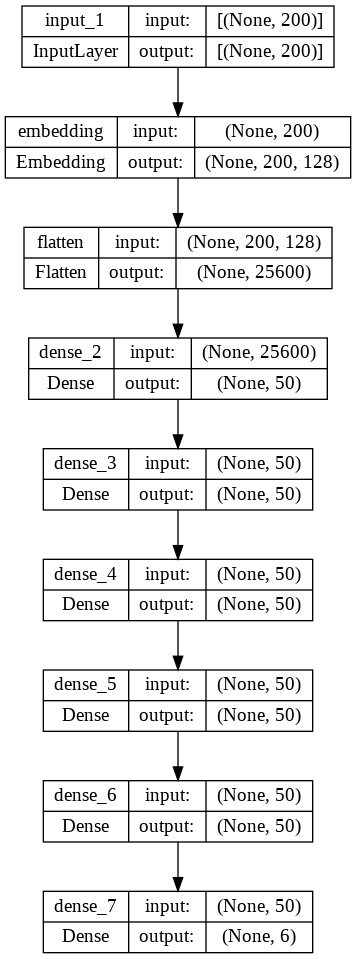

Epoch 1/2
3990/3990 [==============================] - 30s 7ms/step - loss: 0.0620 - accuracy: 0.9495 - precision: 0.7923 - recall: 0.5700 - val_loss: 0.0563 - val_accuracy: 0.9940 - val_precision: 0.7695 - val_recall: 0.6457
Epoch 2/2
3990/3990 [==============================] - 29s 7ms/step - loss: 0.0473 - accuracy: 0.9829 - precision: 0.8179 - recall: 0.6651 - val_loss: 0.0565 - val_accuracy: 0.9941 - val_precision: 0.7847 - val_recall: 0.6449


In [ ]:
l = Flatten()(e)
l = Dense(50, activation='relu') (l)
for _ in range(4):
  l = Dense(50, activation='relu') (l)
l = Dense(6, activation="sigmoid")(l)
predict_dl(inp, l, 2)

# Shallow nueral network

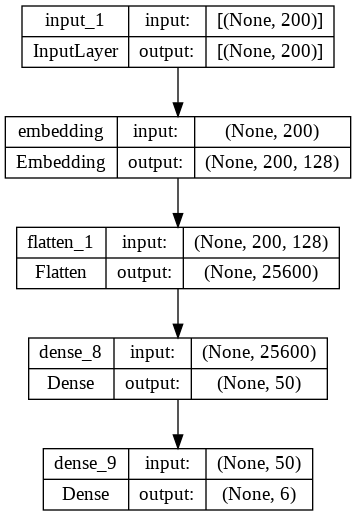

Epoch 1/10
3990/3990 [==============================] - 26s 6ms/step - loss: 0.0530 - accuracy: 0.7296 - precision: 0.8139 - recall: 0.6773 - val_loss: 0.0705 - val_accuracy: 0.8356 - val_precision: 0.8155 - val_recall: 0.5825
Epoch 2/10
3990/3990 [==============================] - 30s 7ms/step - loss: 0.0355 - accuracy: 0.6470 - precision: 0.8536 - recall: 0.7836 - val_loss: 0.0745 - val_accuracy: 0.8969 - val_precision: 0.7722 - val_recall: 0.6134
Epoch 3/10
3990/3990 [==============================] - 35s 9ms/step - loss: 0.0272 - accuracy: 0.5450 - precision: 0.8841 - recall: 0.8344 - val_loss: 0.0857 - val_accuracy: 0.6190 - val_precision: 0.7718 - val_recall: 0.6086
Epoch 4/10
3990/3990 [==============================] - 27s 7ms/step - loss: 0.0212 - accuracy: 0.5293 - precision: 0.9092 - recall: 0.8761 - val_loss: 0.0970 - val_accuracy: 0.6051 - val_precision: 0.7240 - val_recall: 0.6322
Epoch 5/10
3990/3990 [==============================] - 26s 6ms/step - loss: 0.0169 - accura

In [ ]:
l = Flatten()(e)
l = Dense(50, activation='relu') (l)
l = Dense(6, activation="sigmoid")(l)
predict_dl(inp, l, 10)

# GRU

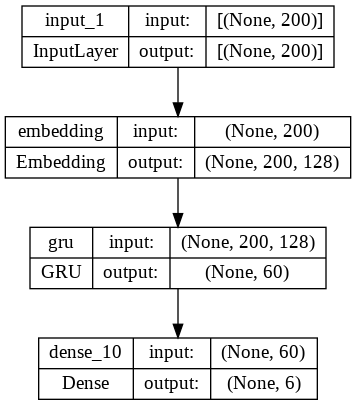

Epoch 1/2
3990/3990 [==============================] - 55s 13ms/step - loss: 0.0427 - accuracy: 0.9524 - precision: 0.8236 - recall: 0.7228 - val_loss: 0.0533 - val_accuracy: 0.8706 - val_precision: 0.7502 - val_recall: 0.7128
Epoch 2/2
3990/3990 [==============================] - 52s 13ms/step - loss: 0.0290 - accuracy: 0.8567 - precision: 0.8672 - recall: 0.8150 - val_loss: 0.0575 - val_accuracy: 0.8238 - val_precision: 0.7177 - val_recall: 0.7226


In [ ]:
l = GRU(60, activation='tanh') (e)
l = Dense(6, activation="sigmoid")(l)
predict_dl(inp, l, 2)

# CNN

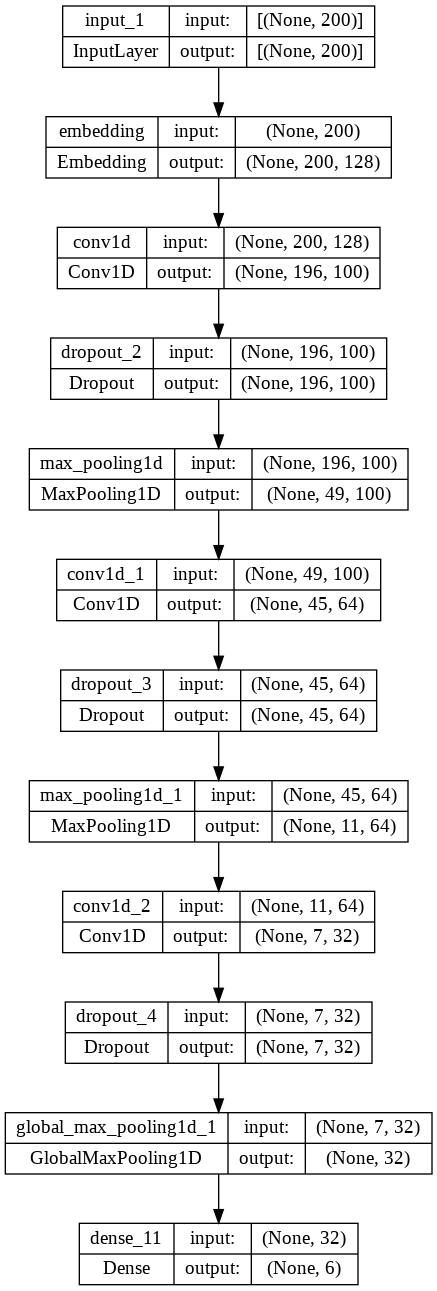

Epoch 1/2
3990/3990 [==============================] - 40s 9ms/step - loss: 0.0838 - accuracy: 0.7563 - precision: 0.7725 - recall: 0.3835 - val_loss: 0.0909 - val_accuracy: 0.8221 - val_precision: 0.7218 - val_recall: 0.4161
Epoch 2/2
3990/3990 [==============================] - 33s 8ms/step - loss: 0.0719 - accuracy: 0.7234 - precision: 0.8112 - recall: 0.4555 - val_loss: 0.0877 - val_accuracy: 0.5582 - val_precision: 0.7978 - val_recall: 0.3575


In [ ]:
l = Conv1D(100, 5, activation='relu') (e)
l = Dropout(0.1) (l)
l = MaxPooling1D(pool_size=4) (l)
l = Conv1D(64, 5, activation='relu') (l)
l = Dropout(0.1) (l)
l = MaxPooling1D(pool_size=4) (l)
l = Conv1D(32, 5, activation='relu') (l)
l = Dropout(0.1) (l)
l = GlobalMaxPool1D() (l)
l = Dense(6, activation="sigmoid")(l)
predict_dl(inp, l, 2)